# Peer-graded Assignment: Оценка эффекта от внедрения полученного решения

Оценка потенциального экономического эффекта от внедрения полученного решения

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:

сколько денег в среднем приносит один пользователь в месяц;  
сколько денег в среднем вы будете вкладывать в удержание одного пользователя;  
с какой вероятностью пользователь примет ваше предложение;  
сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import warnings as wrn
wrn.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


#### Загрузим значения прогнозов модели для Hold out выборки 

In [3]:
df_res=pd.read_csv("churn_prediction_result.csv",index_col =0)

In [8]:
churn_det=df_res[df_res["1"]>0.5].sort_values("1",ascending=False)

Нам нужны только значения, где модель спрогнозирована отток.  
Отсортируем по убыванию уверенности модели в прогнозе.  
Построим ряды значений True positive и False positive

In [5]:
TPs=churn_det["label"].values.cumsum()

In [6]:
FPs=1+np.arange(len(churn_det))-TPs

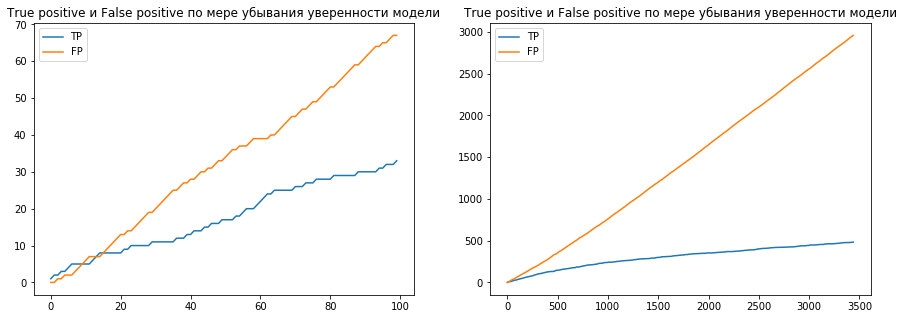

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(TPs[:100],label="TP")
plt.plot(FPs[:100],label="FP")
plt.title("True positive и False positive по мере убывания уверенности модели")
plt.legend()

plt.subplot(1,2,2)
plt.plot(TPs,label="TP")
plt.plot(FPs,label="FP")
plt.title("True positive и False positive по мере убывания уверенности модели")
plt.legend()
plt.show()

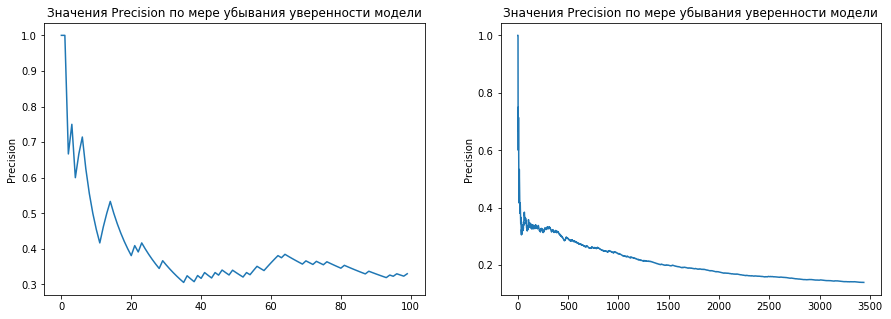

In [35]:
precisions=TPs/(TPs+FPs)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(precisions[:100])
plt.ylabel("Precision")
plt.title("Значения Precision по мере убывания уверенности модели")
plt.subplot(1,2,2)
plt.plot(precisions)
plt.ylabel("Precision")
plt.title("Значения Precision по мере убывания уверенности модели")
plt.show()

Как мы видим, значение метрики Precision ухудшается по мере убывания уверенности модели. Так для Топ %1 она будет лучше, чем для Топ 25%

### 1. Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Прибыль кампании будем измерять по формуле:
$$Revenue= arpu \cdot TP\cdot agreedrate - retentioncostperuser\cdot (TP \cdot agreedrate + FP) $$

* TP - число клиентов из Топ, правильно отнесенных к классу "отток"
* FP - число клиентов из Топ, ошибочно отнесенных к классу "отток"
* agreedrate - вероятность принятия предложения для клиента из класса "отток"
* retentioncostperuser - стоимость затрат на одного клиента, участвующего в акции. Будем считать, как долю от arpu 

In [19]:
def revenue_campaign(retention_cost_per_user,agreed_rate, top_percent):
    TP=TPs[top_percent*len(TPs)//100]
    FP=FPs[top_percent*len(FPs)//100]   
    arpu=1
    return arpu*(TP * agreed_rate) -retention_cost_per_user* (TP * agreed_rate + FP)

#### 2. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

    Допустим стоимость удержания одного пользователя 10% от Average Revenue per user. Наше предложение принимают 70% пользователей, которые хотели уйти (True Positive) и 100% тех, кто уходить не хотел, но модель их ошибочно выбрала (False Positive)

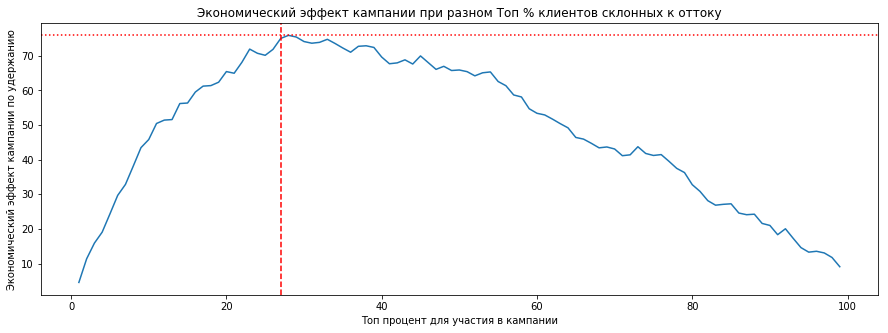

Наибольшая прибыль 75.88 от кампании достигается при Топ 27 % пользователей склонных к оттоку согласно модели


In [389]:
plt.figure(figsize=(15,5))
perc=1+np.arange(99)
plt.plot(perc,revenue_campaign(0.1,0.7, perc))
plt.title("Экономический эффект кампании при разном Топ % клиентов склонных к оттоку")
plt.xlabel("Топ процент для участия в кампании")
plt.ylabel("Экономический эффект кампании по удержанию")
best_perc=np.argmax(revenue_campaign(0.1,0.7, perc))
max_rev=revenue_campaign(0.1,0.7, perc)[best_perc]
plt.axvline(best_perc,linestyle="--",color="r")
plt.axhline(max_rev,linestyle=":",color="r")
plt.show()
print("Наибольшая прибыль {:1.2f} от кампании достигается при Топ {:d} % пользователей склонных к оттоку согласно модели".format(max_rev, best_perc))

#### 3. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

In [20]:
def max_revenue(retention_costs,agreed_rates):
    perc=1+np.arange(99)
    best_perc=np.argmax(revenue_campaign(retention_costs,agreed_rates, perc))
    max_rev=revenue_campaign(retention_costs,agreed_rates, perc)[best_perc]
    return max_rev

In [21]:
def optimal_percent(retention_costs,agreed_rates):
    perc=1+np.arange(99)
    best_perc=np.argmax(revenue_campaign(retention_costs,agreed_rates, perc))
    #max_rev=revenue_campaign(retention_costs,agreed_rates, perc)[best_perc]
    return best_perc

**Чем меньше стоимость удержания и чем выше вероятность принятия предложения - для большего Топ пользователей склонных к оттоку удержание экономически оптравданно**  
Так, при стоимости удержания 0 - оптимальный Топ - 98%, а при значениях больше 0.5 - 0%, т.е. оптимально не начинать кампанию, так как она будет убыточна

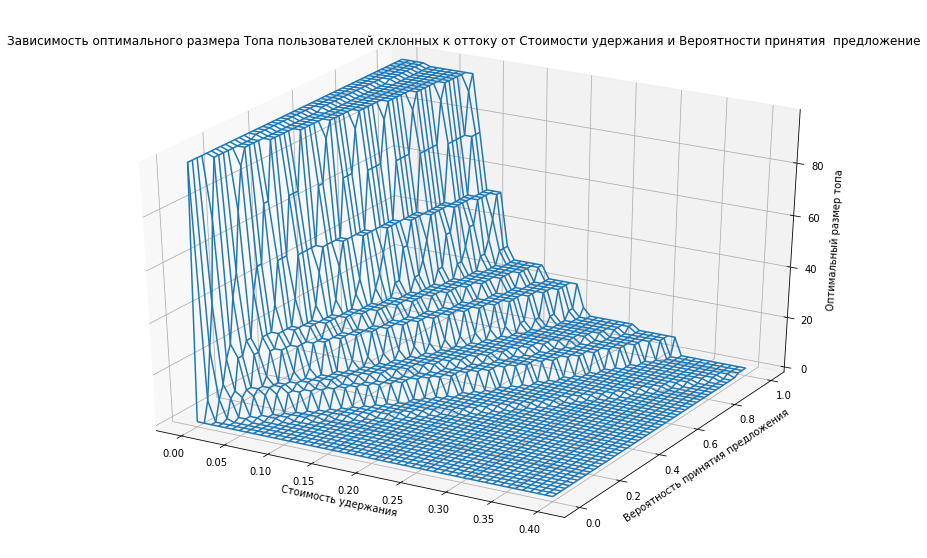

In [405]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.linspace(0.0, 0.4, 50)#retention_costs
Y = np.linspace(0.0, 1, 50)#agreed_rates
X, Y = np.meshgrid(X, Y)

opt_perc=np.vectorize(lambda r_c, a_r: optimal_percent(r_c,a_r))

Z = opt_perc(X, Y)

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('Стоимость удержания')#retention_costs
ax.set_ylabel('Вероятность принятия предложения')#agreed_rates
ax.set_zlabel('Оптимальный размер топа')
plt.title('Зависимость оптимального размера Топа пользователей склонных к оттоку от Стоимости удержания и Вероятности принятия  предложение')
fig.set_size_inches(15,10)
plt.show()

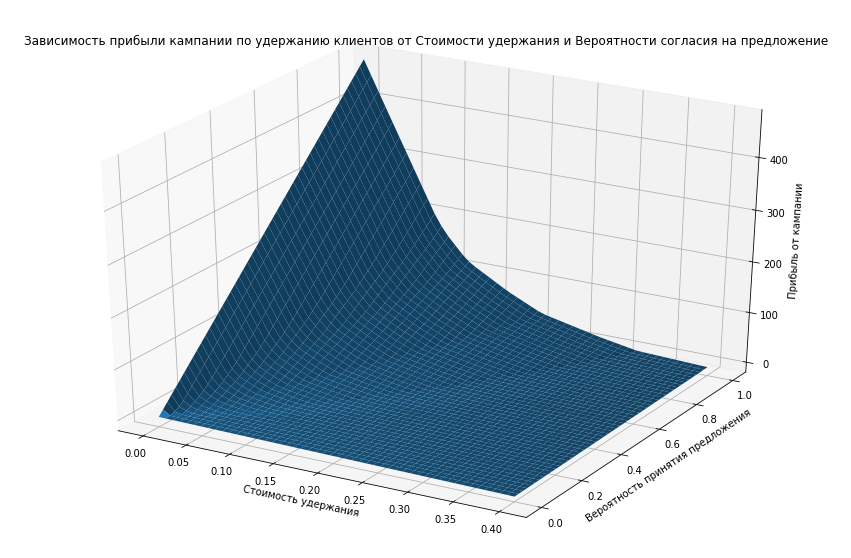

In [404]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.linspace(0.0, 0.4, 50)#retention_costs
Y = np.linspace(0.0, 1, 50)#agreed_rates
X, Y = np.meshgrid(X, Y)

max_rev=np.vectorize(lambda r_c, a_r: max_revenue(r_c,a_r))

Z = max_rev(X, Y)

surf = ax.plot_surface(X, Y, Z)

ax.set_xlabel('Стоимость удержания')#retention_costs
ax.set_ylabel('Вероятность принятия предложения')#agreed_rates
ax.set_zlabel('Прибыль от кампании')
plt.title('Зависимость прибыли кампании по удержанию клиентов от Стоимости удержания и Вероятности согласия на предложение')
fig.set_size_inches(15,10)
plt.show()

**Чем меньше стоимость удержания и чем выше вероятность принятия предложения - тем выше максимальная прибыль от проведения кампании**  
Так, при стоимости удержания 0 и вероятности принятия предложения 100% - максимальная прибыль 479, а при значениях стоимости удержания больше 0.5 - максимальная прибыль 0, т.е. оптимально не начинать кампанию, так как она будет убыточна

### 4. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

**Нет, применение модели экономически оправданно не всегда. Изменим условия из пункта 2 - стоимость удержания установим 0.5, а вероятность принятия предложения оставим прежней - 0.7  
В этом случае кампания будет убыточной при любых значениях Топ пользоватей склонных к оттоку**

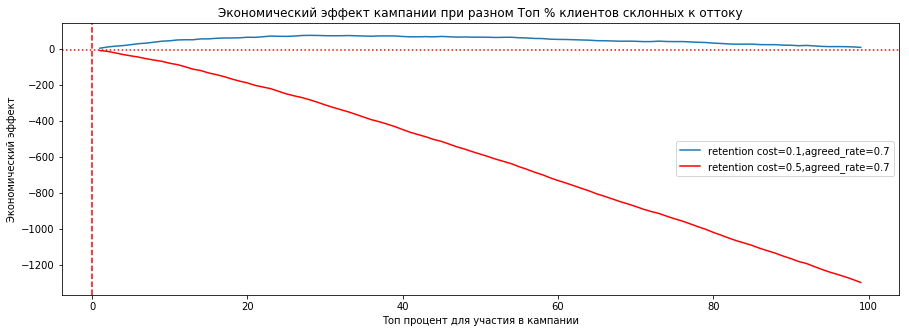

In [25]:
plt.figure(figsize=(15,5))
perc=1+np.arange(99)
plt.plot(perc,revenue_campaign(0.1,0.7, perc),label="retention cost=0.1,agreed_rate=0.7")
plt.plot(perc,revenue_campaign(0.5,0.7, perc),color="r",label="retention cost=0.5,agreed_rate=0.7")
plt.xlabel("Топ процент для участия в кампании")
plt.ylabel("Экономический эффект")
best_perc=np.argmax(revenue_campaign(0.5,0.7, perc))
max_rev=revenue_campaign(0.5,0.7, perc)[best_perc]
plt.axvline(best_perc,linestyle="--",color="r")
plt.axhline(max_rev,linestyle=":",color="r")
plt.legend()
plt.title("Экономический эффект кампании при разном Топ % клиентов склонных к оттоку")
plt.show()

### 5. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

Построенная экономическая можель зависит от True positive и False positive, поэтому ключевой для является метрика Precision
Изменим функцию так, чтобы можно было влиять на метрику Precision

In [22]:
def revenue_campaign_improove(retention_cost_per_user,agreed_rate, top_percent,improove_pr_by=0):
    TP=TPs[top_percent*len(TPs)//100]
    FP=FPs[top_percent*len(FPs)//100]   
    
    if (improove_pr_by>0):
        precisions=TP/(TP+FP)
        TP=precisions*(1+improove_pr_by)*top_percent*len(FPs)/100
        FP=top_percent*len(FPs)/100-TP
        
    arpu=1
    return arpu*(TP * agreed_rate) -retention_cost_per_user* (TP * agreed_rate + FP)

In [23]:
def revenue_campaign_by_pr(retention_cost_per_user,agreed_rate, precision):
    top_percent=1
    count=1
    TP=precision*top_percent*count#/100
    FP=(1-precision)*top_percent*count#/100
    arpu=1
    return arpu*(TP * agreed_rate) -retention_cost_per_user* (TP * agreed_rate + FP)

In [24]:
def max_revenue(retention_costs,agreed_rates,improove_pr_by=0):
    perc=1+np.arange(99)
    best_perc=np.argmax(revenue_campaign_improove(retention_costs,agreed_rates, perc,improove_pr_by))
    max_rev=revenue_campaign_improove(retention_costs,agreed_rates, perc,improove_pr_by)[best_perc]
    return max_rev

In [333]:
def optimal_percent(retention_costs,agreed_rates,improove_pr_by=0):
    perc=1+np.arange(99)
    best_perc=np.argmax(revenue_campaign_improove(retention_costs,agreed_rates, perc,improove_pr_by))
    #max_rev=revenue_campaign_improove(retention_costs,agreed_rates, perc,improove_pr_by)[best_perc]
    return best_perc

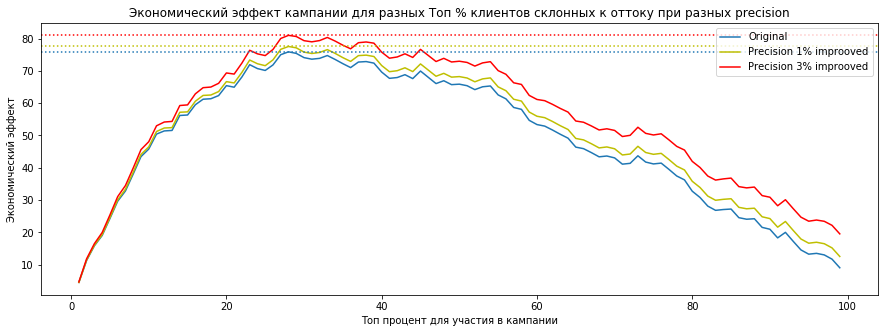

Наибольшая прибыль при исходной модели: 75.9 
С улучшенным Precision на 1%: 		77.5 
С улучшенным Precision на 3%: 		81.0


In [26]:
plt.figure(figsize=(15,5))
perc=1+np.arange(99)
plt.plot(perc,revenue_campaign(0.1,0.7, perc), label="Original")
plt.plot(perc,revenue_campaign_improove(0.1,0.7, perc,0.01),color="y", label="Precision 1% improoved")
plt.plot(perc,revenue_campaign_improove(0.1,0.7, perc,0.03),color="r", label="Precision 3% improoved")

best_perc=np.argmax(revenue_campaign(0.1,0.7, perc))
max_rev=revenue_campaign(0.1,0.7, perc)[best_perc]
max_rev1=np.max(revenue_campaign_improove(0.1,0.7, perc,0.01))
max_rev3=np.max(revenue_campaign_improove(0.1,0.7, perc,0.03))
plt.axhline(max_rev,linestyle=":")
plt.axhline(max_rev1,linestyle=":",color="y")
plt.axhline(max_rev3,linestyle=":",color="r")
plt.xlabel("Топ процент для участия в кампании")
plt.ylabel("Экономический эффект")
plt.title("Экономический эффект кампании для разных Топ % клиентов склонных к оттоку при разных precision")
plt.legend(loc="upper right")
plt.show()
print("Наибольшая прибыль при исходной модели: {:1.1f} \nС улучшенным Precision на 1%: \t\t{:1.1f} \nС улучшенным Precision на 3%: \t\t{:1.1f}".format(*np.round((max_rev, max_rev1,max_rev3),1)))

**Построим графики изменения "Значений максимальной прибыли" и "Оптимального Топа" при улучшении Precision на 3%**

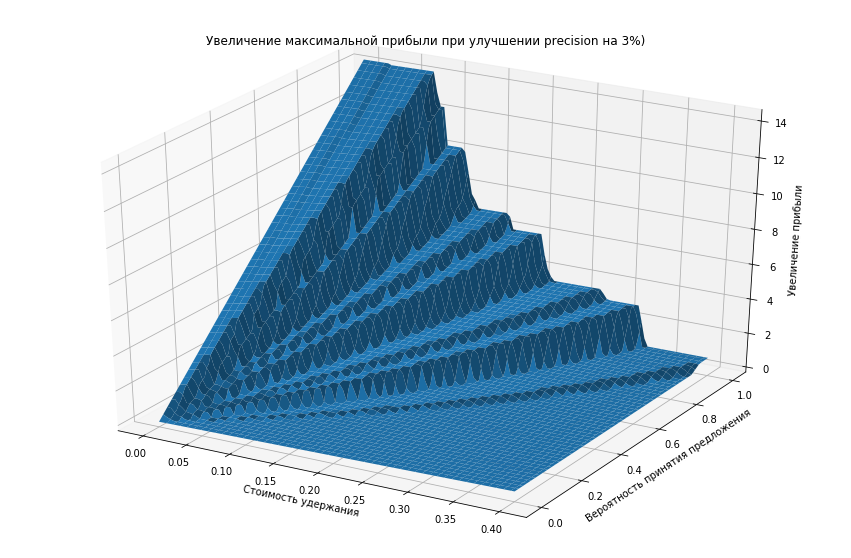

In [406]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.linspace(0.0, 0.4, 100)#retention_costs
Y = np.linspace(0.0, 1, 100)#agreed_rates
X, Y = np.meshgrid(X, Y)

max_rev=np.vectorize(lambda r_c, a_r: max_revenue(r_c,a_r))
max_rev_imp=np.vectorize(lambda r_c, a_r: max_revenue(r_c,a_r,0.03))

Z = max_rev(X, Y)

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.

Z2 = max_rev_imp(X, Y)
surf = ax.plot_surface(X, Y, Z2-Z)#,color="y")

ax.set_xlabel('Стоимость удержания')#retention_costs
ax.set_ylabel('Вероятность принятия предложения')#agreed_rates
ax.set_zlabel('Увеличение прибыли')
plt.title('Увеличение максимальной прибыли при улучшении precision на 3%)')
fig.set_size_inches(15,10)
plt.show()

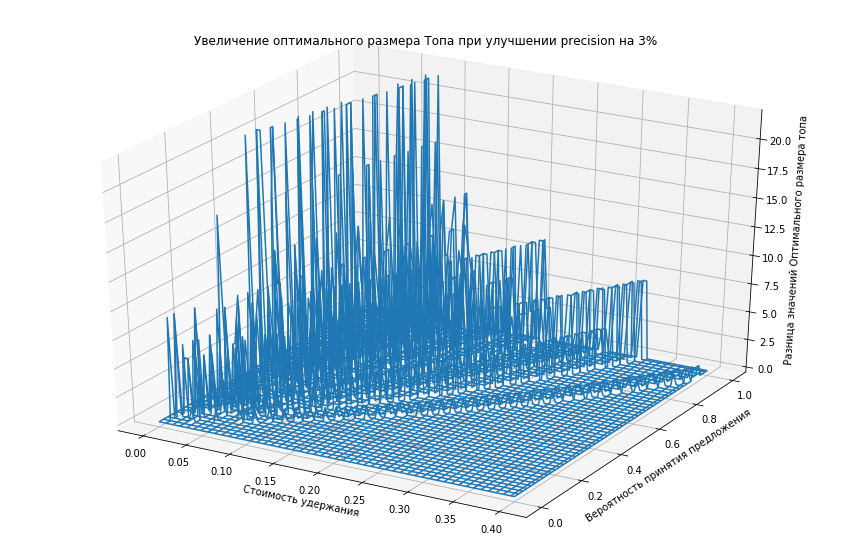

In [407]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.linspace(0.0, 0.4, 100)#retention_costs
Y = np.linspace(0.0, 1, 100)#agreed_rates
X, Y = np.meshgrid(X, Y)

opt_perc=np.vectorize(lambda r_c, a_r: optimal_percent(r_c,a_r))
opt_perc_imp=np.vectorize(lambda r_c, a_r: optimal_percent(r_c,a_r,0.03))

Z = opt_perc(X, Y)


# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.

Z2 = opt_perc_imp(X, Y)

surf = ax.plot_wireframe(X, Y, Z2-Z)#,color="y")

ax.set_xlabel('Стоимость удержания')#retention_costs
ax.set_ylabel('Вероятность принятия предложения')#agreed_rates
ax.set_zlabel('Разница значений Оптимального размера топа')
plt.title('Увеличение оптимального размера Топа при улучшении precision на 3%')
fig.set_size_inches(15,10)
plt.show()

***При улучшении метрики precision на 3% максимальная прибыль увеличилась. Значения опмимального размера Топ пользователей также улучшился**

### 6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

**Думаю, что явложение средств в улучшение качества модели вляется экономически оправданным. Даже улучшение качества прогзнозана нескольно процентов дает ощутимый эффект. В масштабах реального бизнеса это может сэкономить значительные средства**